<a href="https://colab.research.google.com/github/kabann-1978/Flowise/blob/main/exemplo_rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
# exemplo de rede neural que reconhece dígitos

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [79]:
transform = transforms.ToTensor() # define a conversão de imagem para tensor, pq se deixar em jpeg o desempenho não é tão bom como em "tensor"

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=36, shuffle=True) # cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #carrega a parte de validadção do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=36, shuffle=True) # cria um buffer para pegar os dados por partes

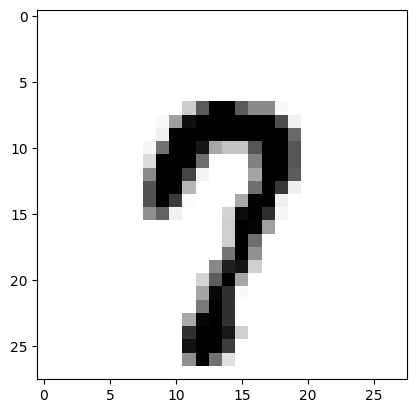

In [80]:
# exibe uma imagem da importação

dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [81]:
print(imagens[0].shape) # verifica as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # verifica as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [82]:
# define a estrutura da rede neural

class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurôneos que se ligam a 128
    self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurôneos que se ligam a 64
    self.lienar3 = nn.Linear(64, 10) # camada interna 2, 64 neurôneos que se ligam a 10

# para a camada de saída não é necessário definir nada, pois só precisamos pegar o output da camada interna 2

def forward(self, x):
  x = F.relu(self.linear1(x)) # função que ativa a camada de entrada para a camada interna 1
  x = F.relu(self.linear2(x)) # função que ativa a camada interna 1 para a camada 2
  x = F.self.lienar3(x) # função que ativa a camada interna 2 para a camada de saída (f(x)=x)
  return F.log_softmax(x,dim=1) # dados usados para cálculo da perda



In [83]:
# define o modelo de treinamento da rede neural

def treino(modelo, treinloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a política de atualização dos pesos e das bias
  inicio = time() # timer definido para saber quanto tempo levou o treino da rede

  criterio = nn.NLLLoss() # define o critério para calcular a perda
  EPOCHS = 10 # número constante de epochs que o algoritmo irá processar (ideal é pelo menos 100, porém, leva muito tempo, para efeito de estudo está somente 10)
  modelo.train() # ativa o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # converte as imagens para "vetores" de 28*28 casas para ficarem compatíveis
      otimizador.zero_grad() # zera os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # coloca os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calcula a perda da epoch em utilizada no momento

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() # atualiza os pesos e as bías

      perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) ",(time()-inicio)/60)


In [84]:
# compara uma imagem não treinada com as imagens treinadas

def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1,784)

      # Desativa o autograd para acelerar a validação. Os grafos computacionais possuem um alto custo computacional

      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo de escala logarítimica


      ps = torch.exp(logps) # converte output para escala normal (lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, neste caso, o número que o modelo previu no treino
      etiqueta_certa = etiquetas.numpy()[1]
      if (etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
        conta_corretas += 1
      conta_todas += 1
  print("Total de imagens testadas *", conta_todas)
  print("\nPrecisão do modelo * {}%".format(conta_corretas*100/conta_todas))


In [85]:
# instancia o modelo

modelo = Modelo()

# Verifica se possui modelo cuda em GPU, se não, CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (lienar3): Linear(in_features=64, out_features=10, bias=True)
)